### Mô tả về dataset Telco_Churn

Các dữ liệu Telco_Churn là từ hồ sơ thông tin khách hàng của một công ty viễn thông. Mục tiêu của chúng tôi là dự đoán những khách hàng có thể ngừng sử dụng dịch vụ của họ.

Mục tiêu của bài toán là dự đoán Churn. Với Churn trong trường hợp này là Customer Churn, hiểu đơn giản là khi một khách hàng quyết định ngừng sử dụng một dịch vụ hay kết thúc hợp đồng (không muốn gia hạn) với một công ty nào đó. Churn thường được sử dụng trong các công ty kinh doanh với mô hình thanh toán theo kỳ (subscriber-based service model).

Ví dụ như khi các bạn quyết định ngừng sử dụng mạng di động X để chuyển qua dùng mạng của hãng Y. Lúc này các bạn sẽ được coi là churn của công ty X và là khách hàng mới của công ty Y. *Đọc thêm về Churn và Churn Rate* https://data-fun.com/cach-tinh-ty-le-churn-rate-la-gi/

Thông thường bài toán này được giới Data Science áp dụng các mô hình phân loại như DecisionTree, RandomForest, Logistic Regression,... Tuy nhiên, bài viết của mình xin được phép giới thiệu một hướng phân tích khác. Đó là áp dụng Ước tính Kaplan-Meier trong phân tích vòng đời của khách hàng. 

-------------------------------------------------------------
Kiến thức người viết hạn hẹp, cũng như bài viết chỉ mang tính chia sẻ học thuật. Mong được anh em góp ý thêm

#### Lê Đặng Trung Hiếu
*Phòng ABS, CTCP Chứng Khoán Bản Việt (VCSC)*

Tầng 8, Sailing Tower, 111A Pasteur, Quận 1, TpHCM

In [1]:
import hieu_viet_code_ne

#### Quan sát qua  bảng dữ liệu Telco_Churn

Mọi người cũng có thể tải về data này tại: https://www.kaggle.com/blastchar/telco-customer-churn
Hoặc sử dụng file raw trên github của mình https://raw.githubusercontent.com/cafechungkhoan/chu_gia/master/telco_churn.csv

In [2]:
eda = pd.read_csv(r"https://raw.githubusercontent.com/cafechungkhoan/chu_gia/master/telco_churn.csv")
eda = pd.DataFrame(eda)
eda.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,30,30,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,57,1890,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,54,108,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42,1841,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,71,152,Yes


# Ước tính Kaplan-Meier

Ước tính Kaplan-Meier (thường sử dụng trong y học) là một trong những phương pháp được đánh giá là tốt nhất được sử dụng để đo tỷ lệ đối tượng sống trong một khoảng thời gian nhất định sau khi điều trị. Trong các thử nghiệm lâm sàng hoặc thử nghiệm cộng đồng, hiệu quả của một can thiệp y tế nào đó được đánh giá bằng cách đo số lượng đối tượng sống sót hoặc được cứu sau can thiệp đó trong một khoảng thời gian. 

Nền tảng người tạo ra ước lượng này: Paul Meier sinh ngày 24/7/1924 tại Newark (New Jersey), tốt nghiệp cử nhân toán từ trường Oberlin vào năm 1945, tiến sĩ thống kê học từ Đại học Princeton năm 1951 dưới sự hướng dẫn của John Tukey.

Main idea của phương pháp: Ước tính Kaplan-Meier là cách đơn giản nhất để tính toán sự sống sót theo thời gian bất chấp tất cả những khó khăn liên quan đến các đối tượng hoặc tình huống. Survival Curve tính toán xác suất xảy ra sự kiện tại một thời điểm nhất định và nhân xác suất kế tiếp này với xác suất được tính toán trước đó để có được ước tính cuối cùng. 

*Bảng research về survival analysis: Ước tính Kaplan-Meier* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3059453/

*bài giảng của Đại học Princeton: Survival Model* https://data.princeton.edu/wws509/notes/c7.pdf

Trong trường hợp của Telco_Churn, ta có thể gán nhãn Death cho khách hàng rời bỏ dịch vụ, và Survival cho khách hàng vẫn còn duy trì dịch vụ. *Ý tưởng này được trình bày tại đây:* https://support.sas.com/resources/papers/proceedings/proceedings/sugi28/120-28.pdf . Từ ý tưởng này, sử dụng Telco_Churn dataset để trình bày diễn giải.

*Đôi nét về phương pháp: Công thức KP bắt đầu từ năm 1952, khi ông còn giảng dạy ở Đại học Johns Hopkins. Lúc đó, Edward Kaplan đọc một bài báo của Greenwood (người nổi tiếng với công thức Greenwood trong phân tích ung thư) về thời gian bệnh nhân mắc bệnh ung thư. Kaplan liên tưởng đến cách ước tính tuổi thọ của linh kiện điện thoại chôn dưới đáy biển (mà sau này chúng ta biết đến dưới thuật ngữ survival analysis). Ông viết bài báo về cách phân tích survival và đưa bài đó cho John Tukey xem đồng thời nộp cho JASA để công bố. Tukey báo cho ông biết rằng Paul Meier cũng đang nghiên cứu về vấn đề này, và bản thảo cũng đã được nộp cho JASA. Sau này JASA đề nghị hai người (Kaplan và Meier) nên hợp tác viết chung một bài báo, thay vì đăng riêng 2 bài. Phải hơn 4 năm trao đổi và hoàn thiện, sau bài báo mới hoàn chỉnh và được JASA công bố vào năm 1958. Bài báo này khi mới công bố 3 năm đã có 1495 trích dẫn. Cho đến nay, bài báo đã được trích dẫn trên 35.000 lần, trở thành một trong những công trình có ảnh hưởng lớn nhất đến lịch sử khoa học!*

#### Công thức tổng quát của xác suất sống sót tại bất kỳ thời điểm cụ thể nào:

Cách tính Ước tính Kaplan-Meier như sau:

Tương tự như vậy, gán nhãn `Death` cho khách hàng `Churn` (1) và `Survival` cho khách hàng `Not Churn` (0). Và cột `tenure` chính là thời gian tính từ lúc khách hàng đăng kí đến lúc khách hàng rời đi

Encoder cho feature `Churn`

In [5]:
eda['Churn']=eda['Churn'].apply(lambda x: 1 if x == 'Yes' else 0 )

#### Quan sát các Kaplan-Meier và nhận xét

<IPython.core.display.Javascript object>

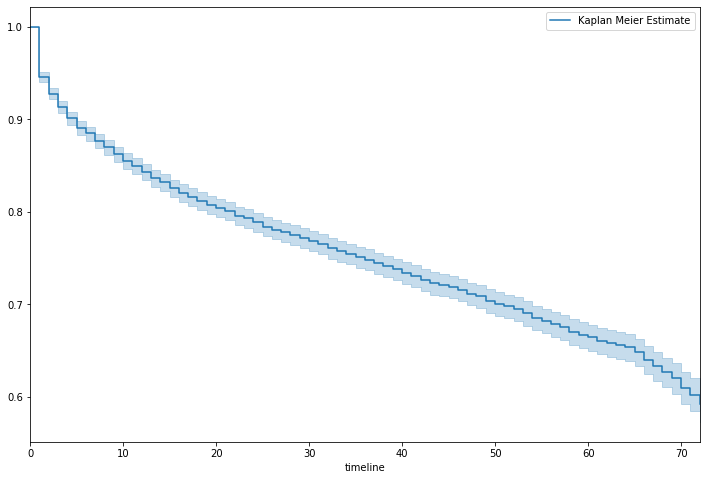

Biểu đồ trên cho biết, sẽ có khoản 20% khách hàng rời đi vào ngày 20, 30% khách hàng rời đi vào ngày 50,....

<IPython.core.display.Javascript object>

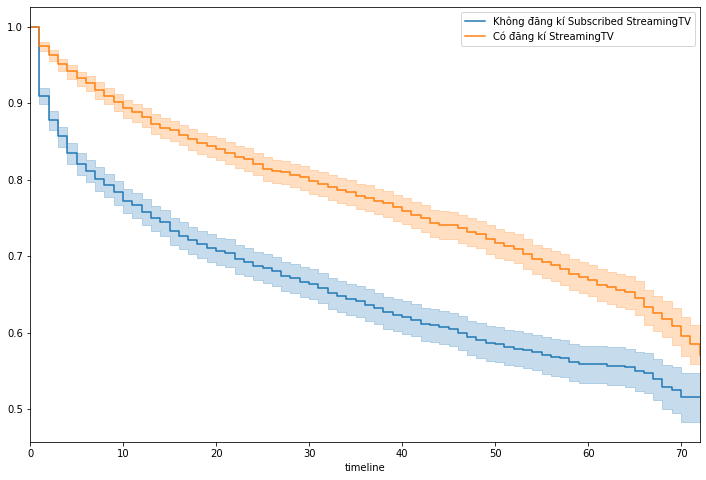

Biểu đồ trên cho biết khách hàng sử dụng Subscribed Streaming TV có xác suất duy trì sử dụng dịch vụ lâu hơn so với khách hàng không đăng kí

<IPython.core.display.Javascript object>

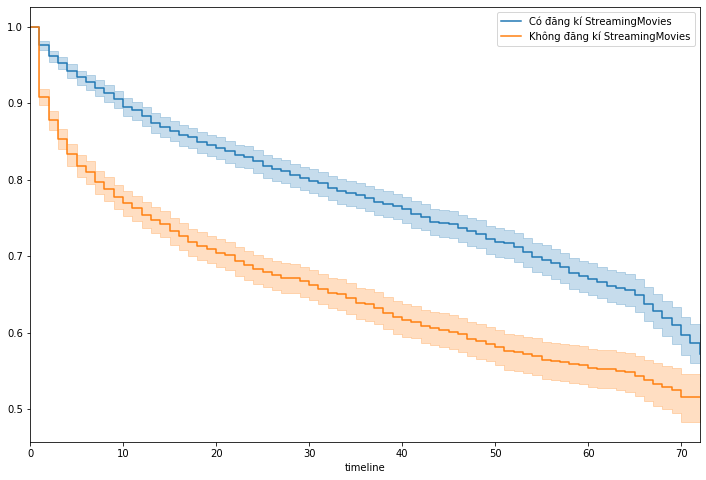

Biểu đồ trên cho biết khách hàng sử dụng StreamingMovies có xác suất duy trì sử dụng dịch vụ lâu hơn so với khách hàng không đăng kí.

Và các yếu tố khác cũng như vậy, biểu diễn từng feature để quan sát thêm. Mình pass qua vấn đề ở đây

# Mô hình Cox (Cox proportional hazards model)

#### Đại ý của model: dự đoán xác xuất rời bỏ dịch vụ của một khách hàng cụ thể theo thời gian
Thông thường nếu biến outcome là biến nhị phân (chỉ có hai giá trị 0/1, yes/no, sống/chết …) thì chúng ta dùng mô hình hồi qui logistic. Nhưng bài toán ở đây khác, biến outcome là biến nhị phân, mà nó lại phụ thuộc vào thời gian theo dõi. Ví dụ như bệnh nhân được điều trị, có người sống suốt thời gian theo dõi, có người chết sau điều trị vài tháng, có người sống đến 2 năm, lại có người chúng ta không biết còn sống hay chết vì không theo dõi được. Trong những trường hợp này, chúng ta dùng mô hình hồi quy Cox (còn gọi là mô hình hazards).

Gọi L(t) là rủi ro (hazard) của một cá nhân tại thời điểm t, mô hình hồi qui Cox phát biểu rằng L(t) được xác định bởi tích số của rủi ro trung bình (L0) và ảnh hưởng của các yếu tố nguy cơ (X1, X2, …, Xk):

L(t) = L0*exp(b1X1 + b2X2 + … + bkXk)

Trong đó, b1, b2, …, bk là hệ số cần phải ước tính từ dữ liệu thực tế. Ví dụ như tôi muốn biết rủi ro bị ung thư trong vòng 5 năm, L(5), của một cá nhân bằng rủi ro trung bình trong quần thể, L0, và ảnh hưởng của các yếu tố như độ tuổi, giới tính, lối sống, gen, v.v.

#### Công thức tổng quát:

In [8]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://miro.medium.com/max/1134/1*_HG7KpWGiGpT4gTVQWyxhg.png")    

#### Trực quan mô hình Cox và Model dự đoán thời xác xuất rời bỏ dịch vụ của một khách hàng cụ thể theo thời gian

Ở bài viết này, mình dùng thư viện `CoxPHFitter` để xử lí `Survival regression`
*đọc thêm về `CoxPHFitter` tại đây* :

In [9]:
from lifelines import CoxPHFitter

#### Sau khi đi qua Feture Selection, mình chọn top các feature sau để chạy mô hình

<IPython.core.display.Javascript object>

In [11]:
df_dummy = pd.get_dummies(df_r, drop_first=True)
cph = CoxPHFitter()
cph.fit(df_dummy, 'tenure', event_col='Churn')
cph.print_summary()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

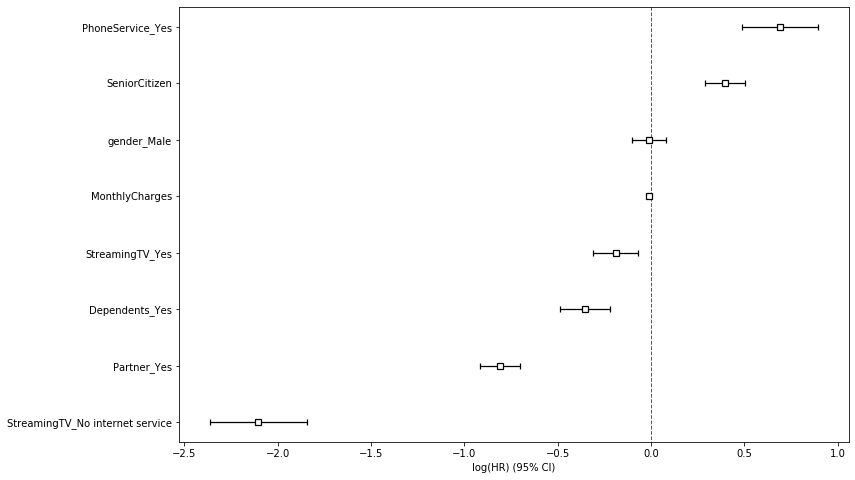

In [12]:
plt.figure(figsize = (12,8))
cph.plot()

#### Tách thử khách hàng thứ 100 đến 110 để quan sát xác xuất rời bỏ dịch vụ theo thời gian

<IPython.core.display.Javascript object>

<Figure size 864x576 with 0 Axes>

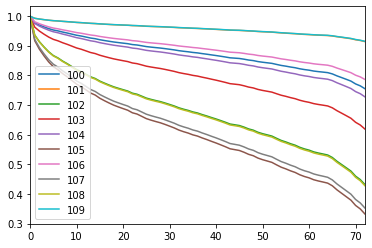

In [13]:
tr_rows = df_dummy.iloc[100:110, 2:]
plt.figure(figsize = (12,8))
cph.predict_survival_function(tr_rows).plot()

#### Kết thúc bài viết ở đây, mong nhận nhiều ý kiến phản hồi của anh em